In [1]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import pandas as pd
from tqdm import tqdm
from scipy.signal import butter, filtfilt

# Implementation of	Music Tonality Features for Speech/Music Discrimination, Gregory Sell and Pascal Clark, IEEE 2014.

In [2]:
import warnings

def extract_features(signal, sr,
                     use_chroma=True,
                     use_mfcc=True,
                     use_low_energy=False):
    feature = []

    try:
        with warnings.catch_warnings():
            warnings.filterwarnings('error')  # convert all warnings to exceptions

            if use_chroma:
                chroma_vectors = librosa.feature.chroma_stft(y=signal, sr=sr, tuning=0.0, n_chroma=36)
                C, T = chroma_vectors.shape
                chroma_diff = np.mean(np.abs(np.diff(chroma_vectors, axis=1)), axis=1)
                feature.append(chroma_diff)

                chroma_fft = np.fft.fft(chroma_vectors, axis=1)
                magnitude = np.abs(chroma_fft[:, 6:19]) ** 2
                hf_energy = np.mean(magnitude, axis=1)
                feature.append(hf_energy)

            if use_mfcc:
                mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)
                mfcc_mean = np.mean(mfcc, axis=1)
                feature.append(mfcc_mean)

            if use_low_energy:
                low_energy_frames = percentage_low_energy_frames(signal, sr)
                feature.append([low_energy_frames])

            return np.concatenate(feature).astype(np.float32)

    except Warning as w:
        # print(f"Skipped chunk due to warning: {str(w)}")
        return None

def percentage_low_energy_frames(signal, sr=16000, win_sec=1.0, hop_length=512, frame_length=1024):
    # Compute RMS energy per frame
    rms = librosa.feature.rms(y=signal, frame_length=frame_length, hop_length=hop_length)[0]
    n_frames = len(rms)
    win_len = int((win_sec * sr) / hop_length)  # frames in 1 sec

    low_energy_count = 0

    # Sliding 1-second window over frames
    for i in range(n_frames):
        start = max(0, i - win_len // 2)
        end = min(n_frames, i + win_len // 2)
        local_mean = np.mean(rms[start:end]) + 1e-6  # prevent division by zero

        if rms[i] < 0.5 * local_mean:
            low_energy_count += 1

    return (low_energy_count / n_frames) * 100


def four_hz_energy(y, sr, n_mels=40):
    mel_spectogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, power=1)
    modulation_energy = 0
    for i in range(n_mels):
        filtered_sig = bandpass_filter(mel_spectogram[i], sr=sr)
        squared = filtered_sig ** 2
        smoothed = np.convolve(squared, np.ones(5)/5, mode='same') 
        total_energy = np.sum(mel_spectogram[i] ** 2) + 1e-6
        normalized = np.sum(smoothed) / total_energy
        modulation_energy += normalized
    return modulation_energy


def bandpass_filter(signal, sr, center_freq=4.0, Q=2.0, order=2, low=None, high=None):
    nyquist = sr / 2
    bw = center_freq / Q
    if low == None and high == None:
        low = (center_freq - bw / 2) / nyquist
        high = (center_freq + bw / 2) / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)


def dataset(csv_path, split='train', target_sr=8000):
    x, y = [], []
    df = pd.read_csv(csv_path)
    df = df[df['split'] == split]
    for _, row in tqdm(df.iterrows(), total=len(df)):
        file_path = row['filename']
        label = row['label']
        if file_path.endswith('.wav'):
            signal, sr = librosa.load(file_path, sr=None)
            if sr != target_sr:
                signal = librosa.resample(y=signal, orig_sr=sr, target_sr=target_sr)
                sr = target_sr
            chunk_duration = 30 
            chunk_length = chunk_duration * sr
            total_length = len(signal)
            for start in range(0, total_length, chunk_length):
                end = start + chunk_length
                if end-start+1 > 0.5*chunk_length and np.mean(np.abs(signal[start:end])) > 1e-4:
                    feat = extract_features(signal[start:end], sr)
                    if feat is None:
                        continue
                    x.append(feat)
                    y.append(label)
        else:
            print(f"No such audio file with {file_path}")
    
    return np.array(x), np.array(y)


In [3]:
import time

csv_path = '/media/sai/tarun/SIP/Project/dataset/final_split.csv'
start_time = time.time()
X_train, Y_train = dataset(csv_path, split='train')
train_fe_time = time.time()
X_test, Y_test = dataset(csv_path, split='test')
test_fe_time = time.time()

  0%|          | 0/974 [00:00<?, ?it/s]

100%|██████████| 240/240 [01:04<00:00,  3.73it/s]


In [4]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((10351, 85), (10351,), (2524, 85), (2524,))

In [5]:
(train_fe_time - start_time) / X_train.shape[0], (test_fe_time-train_fe_time)/X_test.shape[0]

(0.025892290397837893, 0.025524012354776714)

In [6]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create a pipeline with standardization + SVM
clf = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=1.0, gamma='scale')  # RBF kernel works well for most cases
)

# Train on training set
clf.fit(X_train, Y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

In [7]:
y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(Y_test, y_pred))
print(classification_report(Y_test, y_pred))
print(confusion_matrix(Y_test, y_pred))

Accuracy: 0.9920760697305864
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1432
           1       0.99      0.99      0.99      1092

    accuracy                           0.99      2524
   macro avg       0.99      0.99      0.99      2524
weighted avg       0.99      0.99      0.99      2524

[[1418   14]
 [   6 1086]]


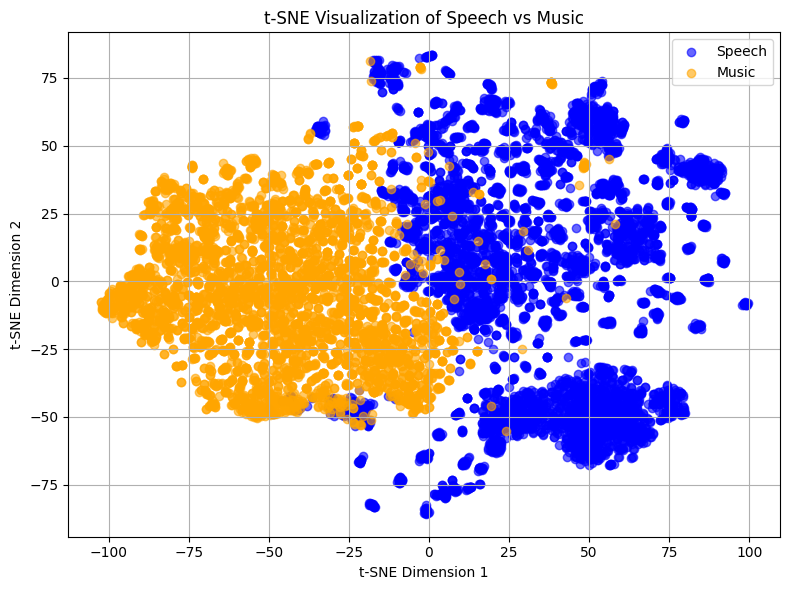

In [8]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# X_train: shape (num_samples, num_features)
# Y_train: shape (num_samples, )

# 1. Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# 2. Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_embedded = tsne.fit_transform(X_scaled)

# 3. Plot with labels
plt.figure(figsize=(8, 6))
plt.scatter(X_embedded[Y_train == 0, 0], X_embedded[Y_train == 0, 1],
            c='blue', label='Speech', alpha=0.6)
plt.scatter(X_embedded[Y_train == 1, 0], X_embedded[Y_train == 1, 1],
            c='orange', label='Music', alpha=0.6)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization of Speech vs Music")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Implementation of Construction and Evaluation of a Robust Multi-feature Speech/Music Discrimination, Eric Scheirer, Malcolm Stanley, IEEE 1997.

In [9]:
from scipy.signal import butter, filtfilt, hilbert
from tqdm import tqdm
import warnings

def extract_features(signal, sr):

    try:
        with warnings.catch_warnings():
            warnings.filterwarnings('error')  # convert all warnings to exceptions

            four_hz_feature = four_hz_energy(signal, sr)
            low_energy_frames = percentage_low_energy_frames(signal, sr)
            spectral_roll_off = compute_spectral_rolloff(signal, sr)
            spectral_centroid = compute_spectral_centroid(signal, sr)
            spectral_flux = compute_spectral_flux(signal, sr)
            zcr = compute_zero_crossing_rate(signal, sr)
            # pulse_metric = compute_pulse_metric(signal, sr)
        
            feature_vector = np.array([
                four_hz_feature,
                low_energy_frames,
                spectral_roll_off[0], spectral_roll_off[1],
                spectral_centroid[0], spectral_centroid[1],
                spectral_flux[0], spectral_flux[1],
                zcr[0], zcr[1],
                # pulse_metric,
                compute_cepstral_residual(signal, sr)
            ], dtype=np.float32)
            return feature_vector
    
    except Warning as w:
        return None


def bandpass_filter(signal, sr, center_freq=4.0, Q=2.0, order=2, low=None, high=None):
    nyquist = sr / 2
    bw = center_freq / Q
    if low == None and high == None:
        low = (center_freq - bw / 2) / nyquist
        high = (center_freq + bw / 2) / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)


def four_hz_energy(y, sr, n_mels=40):
    mel_spectogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, power=1)
    modulation_energy = 0
    for i in range(n_mels):
        if len(mel_spectogram[i]) < 16:
            continue
        filtered_sig = bandpass_filter(mel_spectogram[i], sr=sr)
        squared = filtered_sig ** 2
        smoothed = np.convolve(squared, np.ones(5)/5, mode='same') 
        total_energy = np.sum(mel_spectogram[i] ** 2) + 1e-6
        normalized = np.sum(smoothed) / total_energy
        modulation_energy += normalized
    return modulation_energy


def percentage_low_energy_frames(signal, sr=16000, win_sec=1.0, hop_length=512, frame_length=1024):
    # Compute RMS energy per frame
    rms = librosa.feature.rms(y=signal, frame_length=frame_length, hop_length=hop_length)[0]
    n_frames = len(rms)
    win_len = int((win_sec * sr) / hop_length)  # frames in 1 sec

    low_energy_count = 0

    # Sliding 1-second window over frames
    for i in range(n_frames):
        start = max(0, i - win_len // 2)
        end = min(n_frames, i + win_len // 2)
        local_mean = np.mean(rms[start:end]) + 1e-6  # prevent division by zero

        if rms[i] < 0.5 * local_mean:
            low_energy_count += 1

    return (low_energy_count / n_frames) * 100


def compute_spectral_rolloff(signal, sr=16000, roll_percent=0.95, frame_length=1024, hop_length=512):
    rolloff = librosa.feature.spectral_rolloff(
        y=signal,
        sr=sr,
        roll_percent=roll_percent,
        n_fft=frame_length,
        hop_length=hop_length
    )[0]  # shape: (T,)
    
    rolloff_mean = np.mean(rolloff)
    rolloff_std = np.std(rolloff)
    return rolloff_mean, rolloff_std


def compute_spectral_centroid(signal, sr=16000, frame_length=1024, hop_length=512):
    centroid = librosa.feature.spectral_centroid(y=signal, sr=sr, n_fft=frame_length, hop_length=hop_length)[0]
    return np.mean(centroid), np.std(centroid)


def compute_spectral_flux(signal, sr=16000, frame_length=1024, hop_length=512):
    # Get the magnitude spectrogram
    S = np.abs(librosa.stft(signal, n_fft=frame_length, hop_length=hop_length))
    
    # Normalize spectra (optional, but helps reduce loudness bias)
    S_norm = librosa.util.normalize(S, axis=0)

    # Compute spectral flux
    flux = np.sqrt(np.sum(np.diff(S_norm, axis=1)**2, axis=0))
    
    return np.mean(flux), np.std(flux)


def compute_zero_crossing_rate(signal, frame_length=1024, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=signal, frame_length=frame_length, hop_length=hop_length)[0]
    return np.mean(zcr), np.std(zcr)


def compute_pulse_metric(signal, sr=16000, bands=[(100, 500), (500, 1000), (1000, 2500), (2500, 4000)]):
    acfs = []
    for low, high in bands:
        band_sig = bandpass_filter(signal, sr, low, high)

        # Envelope via Hilbert transform
        envelope = np.abs(hilbert(band_sig))
        envelope = librosa.util.normalize(envelope)

        # Autocorrelation
        acf = np.correlate(envelope, envelope, mode='full')
        acf = acf[len(acf)//2:]  # keep only positive lags

        # Normalize and peak pick
        acf /= np.max(acf) + 1e-6
        peaks = librosa.util.peak_pick(acf, pre_max=10, post_max=10, pre_avg=20, post_avg=20, delta=0.1, wait=10)

        acfs.append(peaks)

    # Compare peak positions across bands
    agreement_score = 0
    for i in range(len(acfs)):
        for j in range(i+1, len(acfs)):
            common = len(np.intersect1d(acfs[i], acfs[j]))
            agreement_score += common

    # Normalize to possible max
    max_possible = (len(acfs) * (len(acfs) - 1)) / 2 * 5  # assuming ~5 peaks per pair
    pulse_metric = agreement_score / (max_possible + 1e-6)

    return pulse_metric


def compute_cepstral_residual(signal, sr=16000, n_fft=1024):
    S = librosa.stft(signal, n_fft=n_fft)
    magnitude, phase = np.abs(S), np.angle(S)

    log_magnitude = np.log1p(magnitude)
    cepstrum = np.fft.ifft(log_magnitude, axis=0).real

    # Keep only low-time quefrency coefficients (e.g., first 20)
    liftered = np.zeros_like(cepstrum)
    liftered[:20, :] = cepstrum[:20, :]

    # Reconstruct spectral envelope
    resynth_log_mag = np.fft.fft(liftered, axis=0).real
    resynth_mag = np.expm1(resynth_log_mag)

    # Reconstruct STFT with original phase
    S_resynth = resynth_mag * np.exp(1j * phase)
    signal_resynth = librosa.istft(S_resynth)

    # Residual signal and its mean energy
    min_len = min(len(signal), len(signal_resynth))
    residual = signal[:min_len] - signal_resynth[:min_len]
    return np.mean(residual ** 2)


def dataset(csv_path, split='train', target_sr=8000):
    x, y = [], []
    df = pd.read_csv(csv_path)
    df = df[df['split'] == split]
    for _, row in tqdm(df.iterrows(), total=len(df)):
        file_path = row['filename']
        label = row['label']
        if file_path.endswith('.wav'):
            signal, sr = librosa.load(file_path, sr=None)
            if sr != target_sr:
                signal = librosa.resample(y=signal, orig_sr=sr, target_sr=target_sr)
                sr = target_sr
            chunk_duration = 30 
            chunk_length = chunk_duration * sr
            total_length = len(signal)
            for start in range(0, total_length, chunk_length):
                end = start + chunk_length
                if end-start+1 > 0.5*chunk_length and np.mean(np.abs(signal[start:end])) > 1e-4:
                    feat = extract_features(signal[start:end], sr)
                    if feat is None:
                        continue
                    x.append(feat)
                    y.append(label)
        else:
            print(f"No such audio file with {file_path}")
    
    return np.array(x), np.array(y)


In [10]:
import time
csv_path = '/media/sai/tarun/SIP/Project/dataset/final_split.csv'
start_time = time.time()
X_train, Y_train = dataset(csv_path, split='train')
train_fe_time = time.time()
X_test, Y_test = dataset(csv_path, split='test')
test_fe_time = time.time()

100%|██████████| 240/240 [03:54<00:00,  1.02it/s]


In [11]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((10352, 11), (10352,), (2525, 11), (2525,))

In [12]:
(train_fe_time-start_time) / X_train.shape[0], (test_fe_time-train_fe_time) / X_test.shape[0]

(0.09338289969118523, 0.09290289151786578)

In [13]:
# Remove rows with NaNs
mask = ~np.isnan(X_train).any(axis=1)
X_train = X_train[mask]
Y_train = Y_train[mask]

mask = ~np.isnan(X_test).any(axis=1)
X_test = X_test[mask]
Y_test = Y_test[mask]

In [14]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create a pipeline with standardization + SVM
clf = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=1.0, gamma='scale')  # RBF kernel works well for most cases
)

# Train on training set
clf.fit(X_train, Y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

In [15]:
y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(Y_test, y_pred))
print(classification_report(Y_test, y_pred))
print(confusion_matrix(Y_test, y_pred))

Accuracy: 0.9877227722772277
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1432
           1       0.99      0.98      0.99      1093

    accuracy                           0.99      2525
   macro avg       0.99      0.99      0.99      2525
weighted avg       0.99      0.99      0.99      2525

[[1418   14]
 [  17 1076]]


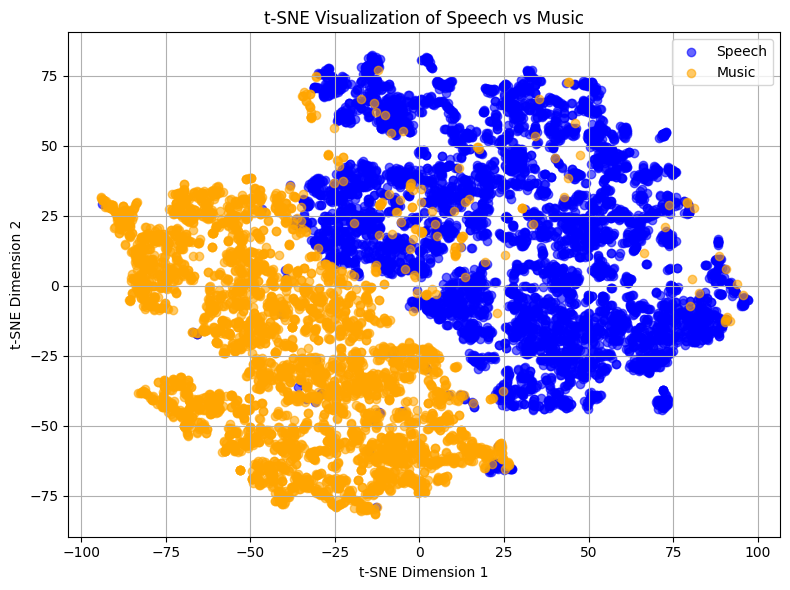

In [16]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# X_train: shape (num_samples, num_features)
# Y_train: shape (num_samples, )

# 1. Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# 2. Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_embedded = tsne.fit_transform(X_scaled)

# 3. Plot with labels
plt.figure(figsize=(8, 6))
plt.scatter(X_embedded[Y_train == 0, 0], X_embedded[Y_train == 0, 1],
            c='blue', label='Speech', alpha=0.6)
plt.scatter(X_embedded[Y_train == 1, 0], X_embedded[Y_train == 1, 1],
            c='orange', label='Music', alpha=0.6)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization of Speech vs Music")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()